<span style="font-family: Arial; font-size: 14pt;"><b>Bias Identification</b></span><br><br>
<span style="font-family: Arial; font-size: 12pt;">Author: Lucas Ma</span>

This program takes in an EEBO file and projects a keyword onto a certain dimension to determine its potential bias.

<b>Section 1: Pre-process the text</b>

In [5]:
import re

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    return text

def load_and_preprocess_file(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    return preprocess_text(text)

file_path = 'data/A10010_uncleaned.txt'
processed_text = load_and_preprocess_file(file_path)


<b>Section 2: Breaking down the text into sentences</b>

In [6]:
def split_into_chunks(text):
    chunks = re.split(r'\. |\! |\.\.\. |\:', text)
    return [chunk.strip() for chunk in chunks if chunk.strip()]

chunks = split_into_chunks(processed_text)

Section 2.5 (checkpoint): Max length of a full sentence present in the file

In [7]:

print(f"The maximum sentence length is: {len(max(chunks, key=len))} characters")

The maximum sentence length is: 1495 characters


<b>Section 3: Generate word embedding among each chunk</b>

In [8]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load pre-trained MacBERTh model and tokenizer
model_name = "fine-tuned-MacBERTh"
# model_name = "emanjavacas/MacBERTh"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_word_embeddings(chunks):
    word_embeddings = {}
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state
        for i, word in enumerate(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])):
            if word not in word_embeddings:
                word_embeddings[word] = embeddings[0, i, :].numpy()
    return word_embeddings

word_embeddings = generate_word_embeddings(chunks)


Some weights of BertModel were not initialized from the model checkpoint at fine-tuned-MacBERTh and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


<b>Section 4: Define the bias axis</b>

In [12]:
import numpy as np

def define_bias_axis(word_embeddings, pair):
    word1, word2 = pair
    return word_embeddings[word1] - word_embeddings[word2]

# Define bias axis for gender
gender_axis = define_bias_axis(word_embeddings, ["he", "she"])

<b>Section 5: Project the embeddings</b>

In [10]:
def project_embeddings(word_embeddings, bias_axis):
    projections = {}
    for word, embedding in word_embeddings.items():
        projection = np.dot(embedding, bias_axis) / np.linalg.norm(bias_axis)
        projections[word] = projection
    return projections

gender_projections = project_embeddings(word_embeddings, gender_axis)

<b>Section 6: Visualize the embedding</b>

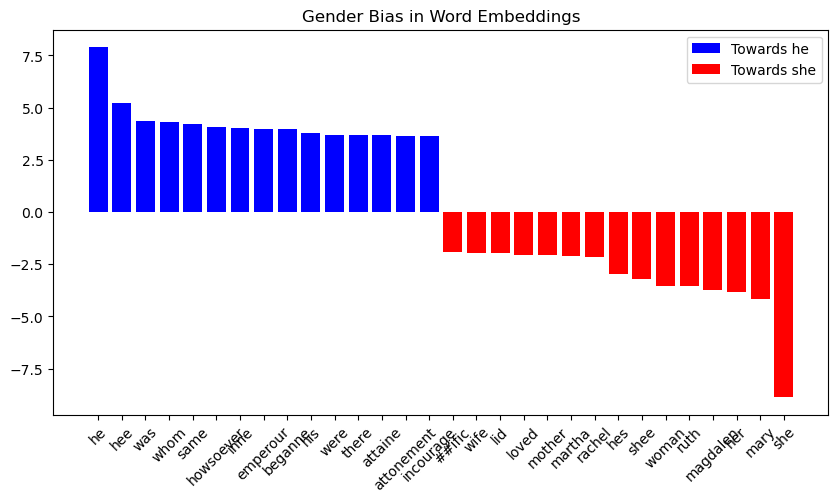

In [23]:
import matplotlib.pyplot as plt

def analyze_projections(projections):
    sorted_projections = sorted(projections.items(), key=lambda item: item[1], reverse=True)
    return sorted_projections

def visualize_bias(projections, title):
    words, values = zip(*projections)
    plt.figure(figsize=(10, 5))
    plt.bar(words[:number_of_entries], values[:number_of_entries], color='b', label='Towards he')
    plt.bar(words[-number_of_entries:], values[-number_of_entries:], color='r', label='Towards she')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

number_of_entries = 15

# Analyze the projections
gender_bias_words = analyze_projections(gender_projections)

# Visualize the bias
visualize_bias(gender_bias_words, "Gender Bias in Word Embeddings")


<b>Alternative Section 6: Single-word projection</b>

In [22]:
import numpy as np

def project_word_on_bias_axis(word, word_embeddings, bias_axis):
    if word not in word_embeddings:
        print(f"Word '{word}' not found in embeddings.")
        return None
    
    # Get the embedding for the word
    word_embedding = word_embeddings[word]
    
    # Project the embedding onto the bias axis
    projection_value = np.dot(word_embedding, bias_axis) / np.linalg.norm(bias_axis)
    
    return projection_value

# Example usage
word_to_project = "mother"
projection_value = project_word_on_bias_axis(word_to_project, word_embeddings, gender_axis)

if projection_value is not None:
    print(f"The projection of the word '{word_to_project}' on the gender bias axis is: {projection_value}")


The projection of the word 'mother' on the gender bias axis is: -2.07210373878479
